**Main imports**

In [72]:
import os
import requests
from tqdm import tqdm
import zipfile
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Imports complete.')


Imports complete.


**Download dataset**

In [ ]:
'''

All code within this block is the property of Amir-Atapour-Abarghouei

'''
# URL of the file
url = "REDACTED"

# make directory if it doesn't exist
directory = 'classification-data'
if not os.path.exists(directory):
    os.makedirs(directory)

# where to save the downloaded file
file_path = os.path.join(directory, 'downloaded_file.zip')

# send a GET request to the URL with stream=True for chunked download
response = requests.get(url, stream=True)

# check if the request was successful
if response.status_code == 200:
    # total size in bytes from the header
    total_size = int(response.headers.get('content-length', 0))

    # progress bar
    with open(file_path, 'wb') as file, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
    ) as progress_bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
                progress_bar.update(len(chunk))

    print("File downloaded successfully!")

    # unzipping
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(directory)
        print(f"Files unzipped successfully in the '{directory}' directory!")

    # remove the zip file after extraction
    os.remove(file_path)
    print("Zip file removed after extraction.")

else:
    print(f"Failed to download the file. Status code: {response.status_code}")

'\nurl = \'https://data.ncl.ac.uk/ndownloader/articles/24574354/versions/1\'\n\n# make directory if it doesn\'t exist\ndirectory = \'classification-data\'\nif not os.path.exists(directory):\n    os.makedirs(directory)\n\n# where to save the downloaded file\nfile_path = os.path.join(directory, \'downloaded_file.zip\')\n\n# send a GET request to the URL with stream=True for chunked download\nresponse = requests.get(url, stream=True)\n\n# check if the request was successful\nif response.status_code == 200:\n    # total size in bytes from the header\n    total_size = int(response.headers.get(\'content-length\', 0))\n\n    # progress bar\n    with open(file_path, \'wb\') as file, tqdm(\n            desc="Downloading",\n            total=total_size,\n            unit=\'B\',\n            unit_scale=True,\n            unit_divisor=1024,\n    ) as progress_bar:\n        for chunk in response.iter_content(chunk_size=1024):\n            if chunk:\n                file.write(chunk)\n              

**Import dataset**

In [74]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

# directory where the data is stored
data_dir = 'classification-data'

# the .npy files
train_x_path = os.path.join(data_dir, 'train_x.npy')
train_y_path = os.path.join(data_dir, 'train_y.npy')
valid_x_path = os.path.join(data_dir, 'valid_x.npy')
valid_y_path = os.path.join(data_dir, 'valid_y.npy')
test_x_path = os.path.join(data_dir, 'test_x.npy')
test_y_path = os.path.join(data_dir, 'test_y.npy')

# load the data
print("Loading data...")
train_x = np.load(train_x_path)
train_y = np.load(train_y_path)
valid_x = np.load(valid_x_path)
valid_y = np.load(valid_y_path)
test_x = np.load(test_x_path)
test_y = np.load(test_y_path)
print("Data loaded successfully.")

# convert NumPy arrays to PyTorch tensors
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
valid_x = torch.from_numpy(valid_x).float()
valid_y = torch.from_numpy(valid_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

print(train_x[0].max(), train_x[0].min())

transform_augment = T.Compose([
    T.ToPILImage(),
    T.RandomAffine(
        degrees=15,
        translate=(0.15, 0.15), 
        scale=(0.85, 1.15), 
        shear=5         
    ),
    T.ToTensor(),
])


class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.labels[idx]

        x = torch.clamp(x, 0, 1)

        if self.transform:
            x = self.transform(x)

        return x, y


# create TensorDataset instances
train_dataset_aug = AugmentedDataset(train_x, train_y, transform=transform_augment)

train_dataset = AugmentedDataset(train_x, train_y, transform=None)
train_combined = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])

valid_dataset = AugmentedDataset(valid_x, valid_y, transform=None)
test_dataset = AugmentedDataset(test_x, test_y, transform=None)

# batch size
batch_size = 256

# DataLoaders
train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Helper function to cycle through the data indefinitely
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# iterators for training, validation, and test loaders
train_iterator = iter(cycle(train_loader))
valid_iterator = iter(cycle(valid_loader))
test_iterator = iter(cycle(test_loader))

# class names
class_names = [str(i) for i in range(20)]

# dataset sizes
print(f'> Size of training dataset: {len(train_combined)}')
print(f'> Size of validation dataset: {len(valid_dataset)}')
print(f'> Size of test dataset: {len(test_dataset)}')


Loading data...
Data loaded successfully.
tensor(2.8215) tensor(-0.4242)
> Size of training dataset: 90000
> Size of validation dataset: 15000
> Size of test dataset: 10000


**View some of the test dataset**

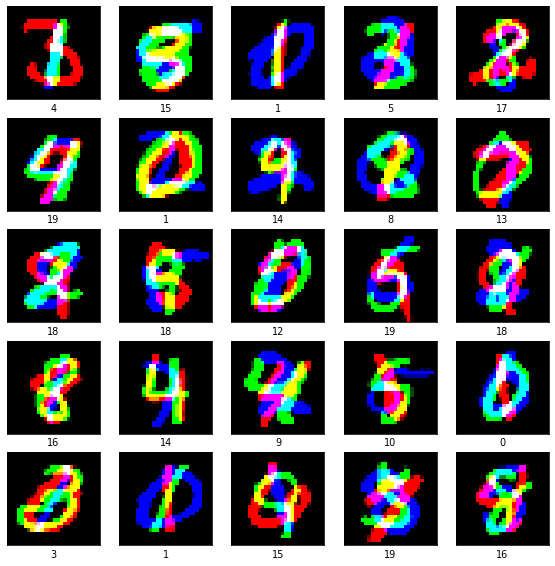

In [ ]:
'''

All code within this block is the property of Amir-Atapour-Abarghouei

'''

plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

**Efficient-Net Implementation**

In [76]:
'''

The implementation of the SqueezeExciteBlock below was implemented based on:
https://www.digitalocean.com/community/tutorials/channel-attention-squeeze-and-excitation-networks

'''
class SqueezeExciteBlock(nn.Module):
    def __init__(self, channel, reduction):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class InvertedResidualBlock(nn.Module):
    def __init__(self, inc, outc, expand, ksize, stride):
        super().__init__()
        if stride == 1 and inc == outc:
            self.residual = True
        else:
            self.residual = False

        intermediate = round(inc * expand)

        self.conv = nn.Sequential(
            nn.Conv2d(inc, intermediate, 1, 1, 0, bias=False),
            nn.BatchNorm2d(intermediate),
            
            nn.SiLU(inplace=True),
            nn.Conv2d(intermediate, intermediate, ksize, stride, ksize//2, groups=intermediate, bias=False),
            nn.BatchNorm2d(intermediate),
            nn.SiLU(inplace=True),
            SqueezeExciteBlock(intermediate, 16),
            #where spatial attention would be, however no gains were observed
            nn.Conv2d(intermediate, outc, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outc)
        )

    def forward(self, x):
        if self.residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

class EfficientNetSmall(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            
            #We use an initial kernel size of 3 to avoid losing
            #too much spatial information for the rest of the model
            
            nn.BatchNorm2d(16),
            nn.SiLU(inplace=True),

            #Each downsample denotes a new block group.
            
            #Block group 1
            InvertedResidualBlock(16, 24, 3, 3, 2),
            InvertedResidualBlock(24, 24, 3, 3, 1),
            InvertedResidualBlock(24, 24, 3, 3, 1),
            InvertedResidualBlock(24, 40, 3, 3, 1),
            InvertedResidualBlock(40, 40, 3, 3, 1),

            #Block group 2
            InvertedResidualBlock(40, 64, 3, 5, 2),
            InvertedResidualBlock(64, 86, 3, 5, 1),
            

            nn.Conv2d(86, 86, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(86),
            nn.SiLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(86, 20)   
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x


# hyperparameters
params = {
    'n_channels': 3,  # number of channels
    'n_hidden':   30, # change to increase parameters
    'n_classes':  20  # number of classes
}

N = EfficientNetSmall(20).to(device)


# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

optimiser = torch.optim.Adam(N.parameters(), lr=0.001, weight_decay=1e-4)
steps_per_epoch = 100
epochs_needed = 10000 // steps_per_epoch
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.004, steps_per_epoch=steps_per_epoch, epochs=epochs_needed)
plot_data = []
steps = 0

> Number of parameters 98720


**Main training and testing loop**

steps: 10000.00, train loss: 0.284, train acc: 0.966±0.011, test acc: 0.941±0.025


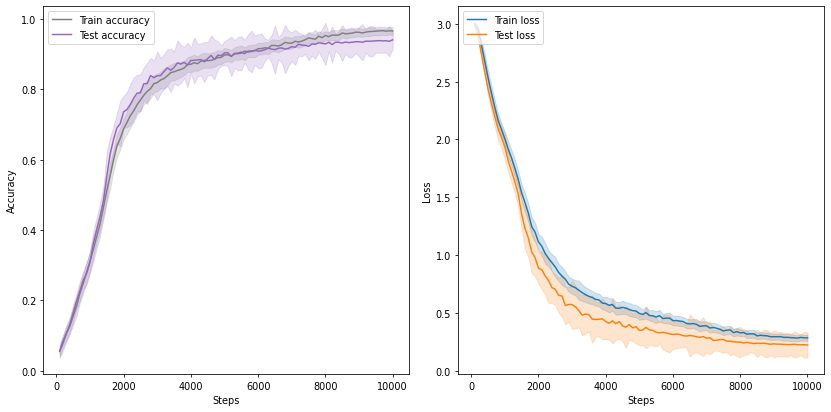

In [77]:
# keep within our optimisation step budget
while (steps < 10000):

    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)
    test_loss_arr = np.zeros(0)

    for i in range(100):
        x, t = next(train_iterator)
        x, t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t, label_smoothing=0.02)
        loss.backward()
        optimiser.step()
        scheduler.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().item())
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    for x, t in test_loader:
        x, t = x.to(device), t.to(device)
        p = N(x)
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())
        test_loss_arr = np.append(test_loss_arr, loss.item())

    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(), train_acc_arr.mean(), train_acc_arr.std(),
        test_acc_arr.mean(), test_acc_arr.std()))

    plot_data.append([
        steps,
        train_acc_arr.mean(), train_acc_arr.std(),
        test_acc_arr.mean(), test_acc_arr.std(),
        train_loss_arr.mean(), train_loss_arr.std(),
        test_loss_arr.mean(), test_loss_arr.std()
    ])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    ax1.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    ax1.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    ax1.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc="upper left")

    ax2.plot([x[0] for x in plot_data], [x[5] for x in plot_data], '-', color='tab:blue', label="Train loss")
    ax2.fill_between([x[0] for x in plot_data], [x[5]-x[6] for x in plot_data], [x[5]+x[6] for x in plot_data], alpha=0.2, color='tab:blue')
    ax2.plot([x[0] for x in plot_data], [x[7] for x in plot_data], '-', color='tab:orange', label="Test loss")
    ax2.fill_between([x[0] for x in plot_data], [x[7]-x[8] for x in plot_data], [x[7]+x[8] for x in plot_data], alpha=0.2, color='tab:orange')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Loss')
    ax2.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    disp.clear_output(wait=True)

**Inference on dataset**

This is useful for analysis but is entirely optional

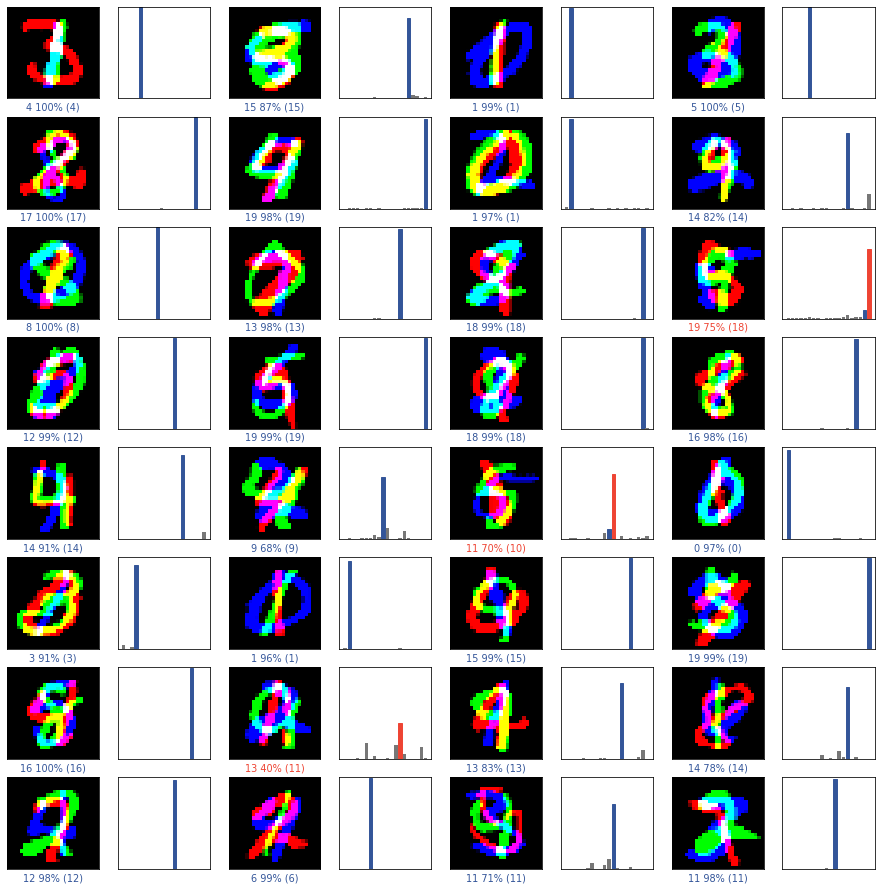

In [ ]:

'''

All code within this block is the property of my professor Amir-Atapour-Abarghouei

'''

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = np.clip(img, 0, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())